# Exemple d'utilisation de GRDZONE
Les accès aux données Sentinel-1 se font à l'aide de l'objet GrdZone.

In [50]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdt
from matplotlib.patches import Rectangle
%matplotlib inline

plt.rcParams["figure.figsize"] = (9,6)

import esg_deforestation_radar as sentinel

In [51]:
%reload_ext autoreload
%autoreload 2

## Définition d'une zone géographique.
Un fichier JSON 'geozone.json' est stocké dans un répertoire de données temporaire.
Ce répertoire sert de cache, les données sources issues de Sentinel Hub se trouve dans un autre répertoire 'GRD'. En général ce second répertoire est un disque serveur de grande capacité.

Le répertoire temporaire sera nommé 'target' et rajouté au dictionnaire issu du JSON.

In [52]:
# Sélection d'une zone géographique.
target = '../data/Barro-Alto'
zone = sentinel.getzone(target)
zone

{'name': 'Barro Alto - Nickel (Brasil)',
 'bbox': [-15.12, -49.06, -15.02, -48.92],
 'step': 10,
 'GRD': '/Volumes/JLTD/Sentinel/GRD/Barro-Alto',
 'FCOVER': '/Volumes/JLTD/Sentinel/FCOVER',
 'NDVI': '/Volumes/JLTD/Sentinel/NDVI',
 'target': '../data/Barro-Alto'}

On commence par créer un objet GrdZone. Cet objet contient la liste de toutes les données disponibles. On peut itérer sur cette liste.

In [53]:
# récupération d'un pointeur sur les images radar.
geo = sentinel.GrdZone(zone)
geo

In [54]:
# Récupération de la liste des images disponibles.
geo.datalist

,FILE
DATE,
2019-04-08,/Volumes/JLTD/Sentinel/GRD/Barro-Alto/ZIP/S1A_...
2019-04-13,/Volumes/JLTD/Sentinel/GRD/Barro-Alto/ZIP/S1A_...
2019-04-20,/Volumes/JLTD/Sentinel/GRD/Barro-Alto/ZIP/S1A_...
2019-04-25,/Volumes/JLTD/Sentinel/GRD/Barro-Alto/ZIP/S1A_...
2019-05-02,/Volumes/JLTD/Sentinel/GRD/Barro-Alto/ZIP/S1A_...
...,...
2021-03-21,/Volumes/JLTD/Sentinel/GRD/Barro-Alto/ZIP/S1A_...
2021-03-28,/Volumes/JLTD/Sentinel/GRD/Barro-Alto/ZIP/S1A_...
2021-04-02,/Volumes/JLTD/Sentinel/GRD/Barro-Alto/ZIP/S1A_...


Les fichiers sont indéxés par la date d'acquisition. On a supprimé l'heure qui ne sert à rien. Les dates maximales et minimales sont facilement récupérables.

In [6]:
# On calcule les valeurs minimales et maximales des bandes sur tout les signaux
vhmin = 100000
vvmin = 100000
vhmax = 0
vvmax = 0
for g in geo:
    bands = g.bandlist()
    vv = geo.band(bands[0])
    vh = geo.band(bands[1])
    vhmin = min(vhmin,vh.min())
    vvmin = min(vvmin,vv.min())
    vhmax = max(vhmax,vh.max())
    vvmax = max(vvmax,vv.max())
vhmin,vhmax,vvmin,vvmax

(6, 14117, 6, 12570)

In [8]:
# Une acquisition peut être récupérée par indexation directe.
geo[3]
geo.datemin, geo.date, geo.datemax

(datetime.date(2019, 4, 8),
 datetime.date(2019, 4, 25),
 datetime.date(2021, 4, 14))

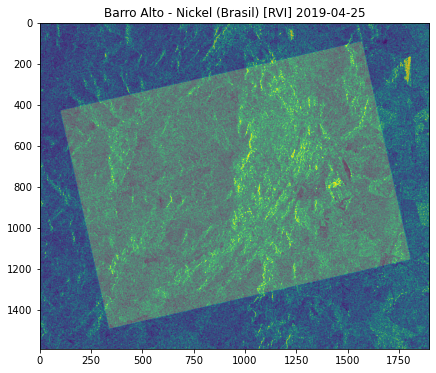

In [9]:
geo.plot()

Elle peut aussi être récupérée par une date, on renvoie alors la dernière acquisition précédente. La position retenue et la date d'acquisition sont enregistrées.

In [48]:
# Récupération de la dernière image avant la date fournie et de sa position.
geo.load('2020-08-01')
geo.pos,str(geo.date)

(76, '2020-07-31')

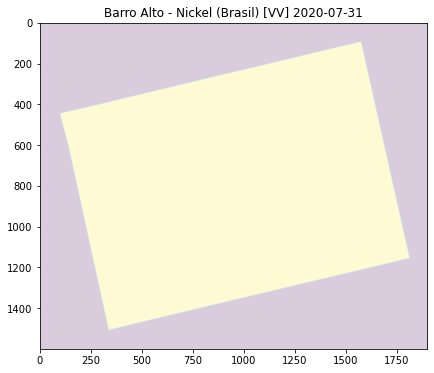

In [49]:
geo.plot('VV')

In [42]:
I = geo.band('VV')
img= I.copy()

In [43]:
q0,q1 = np.quantile(img,[0.05,0.95])
delta = float(q1-q0)
fimg = (1.0*img-q0)/delta


/Users/holie/opt/anaconda3/envs/ee/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/holie/opt/anaconda3/envs/ee/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


L'indexation marche aussi à rebourd. On peut affichier une information directemept par la méthode `plot()`.
L'image stockée est plus grande que la zone étudiée à `zone['STEP']` pixels près, on superpose le masque sur l'image.

In [44]:
q0,q1

(0.0, 0.0)

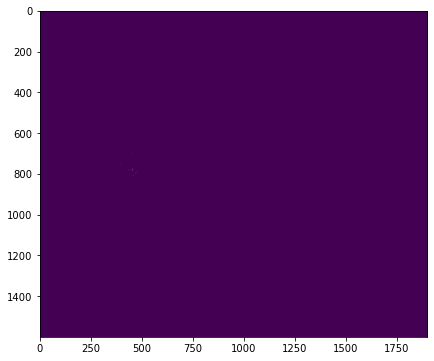

In [32]:
I1 = I
I1[I<200]=0
I1 = (I1-I1.min())/(I1.max()-I1.min())
plt.imshow(I1)

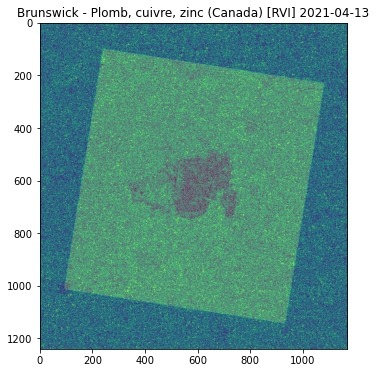

In [136]:
# Affichage de la dernière image.
geo[-1].plot()

Trois bandes sont affichables, le calcul RVI par défaut, mais aussi les polarisations VV ou VH pour SIA et HH et HV pour S1B.

Une fois une acquisition chargée en mémoire, il n'est plus nécessaire de rajouter l'index, mais de toute façon le code ne relancera pas un chargement déjà effectué.

In [137]:
# Récupération des informations sur les bandes.
geo.data

[{'date': datetime.datetime(2021, 4, 13, 22, 20, 5, 951824),
  'polarisation': 'VH',
  'direction': 'Ascending',
  'heigth': 16676,
  'width': 25589,
  'image': array([[ 95, 117,  82, ...,  90,  80,  63],
         [ 99, 108,  81, ...,  90, 111,  74],
         [106, 102,  98, ..., 153, 160,  80],
         ...,
         [136, 110, 111, ..., 108,  88,  90],
         [104,  78,  84, ..., 118, 109, 142],
         [ 84,  54,  79, ..., 111, 143, 173]], dtype=uint16)},
 {'date': datetime.datetime(2021, 4, 13, 22, 20, 5, 951824),
  'polarisation': 'VV',
  'direction': 'Ascending',
  'heigth': 16676,
  'width': 25589,
  'image': array([[205, 169, 205, ..., 158, 133, 150],
         [230, 172, 160, ..., 161, 152, 144],
         [155, 113, 109, ..., 239, 212, 146],
         ...,
         [160, 248, 253, ..., 251, 263, 233],
         [239, 264, 224, ..., 193, 186, 133],
         [188, 204, 206, ..., 172, 209, 196]], dtype=uint16)}]

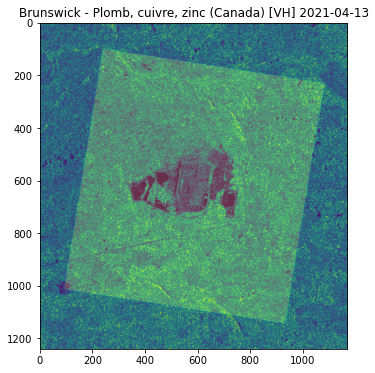

In [138]:
# On remarque que la bande VH existe, il est possible de l'afficher.
geo.plot('VH')

L'imagette encadrant la zone géographique d'intérêt est récupérable.

In [140]:
# On a accès à la liste des bandes + RVI
geo.bandlist()

['VH', 'VV', 'RVI']

In [141]:
# Par défaut, la méthode band() renvoie le RVI.
im = geo.band()
im

array([[1.26666667, 1.63636364, 1.14285714, ..., 1.4516129 , 1.50234742,
        1.18309859],
       [1.20364742, 1.54285714, 1.34439834, ..., 1.43426295, 1.68821293,
        1.35779817],
       [1.62452107, 1.89767442, 1.89371981, ..., 1.56122449, 1.72043011,
        1.4159292 ],
       ...,
       [1.83783784, 1.22905028, 1.21978022, ..., 1.20334262, 1.002849  ,
        1.11455108],
       [1.21282799, 0.9122807 , 1.09090909, ..., 1.51768489, 1.4779661 ,
        2.06545455],
       [1.23529412, 0.8372093 , 1.10877193, ..., 1.56890459, 1.625     ,
        1.87533875]])

Ainsi que le RVI moyen et son écart-type.

In [142]:
# Récupération du RVI moyen sur le masque et de l'écart-type.
geo.meanrvi()

(1.3943368846205555, 0.31246816771145164)

### Affichage du masque.
La zone d'intérêt est inclue dans une image de 250 km x 170 km.
On affiche sa position sur ce graphe.

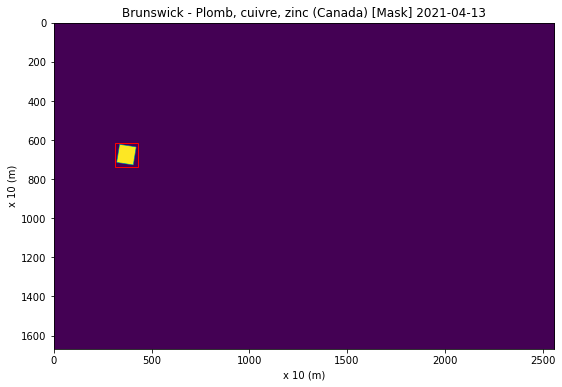

In [143]:
# Affichage du masque dans le cadre de l'image de 251x170 km^2 téléchargée.
# Les imagettes affichées par plot() ou récupérées par band() sont les cadres rouges.
geo.plotmask()

On peut superposer la latitude (Lat) ou la longitude (Lon) pour voir l'orientation de la trajectoire du satellite.

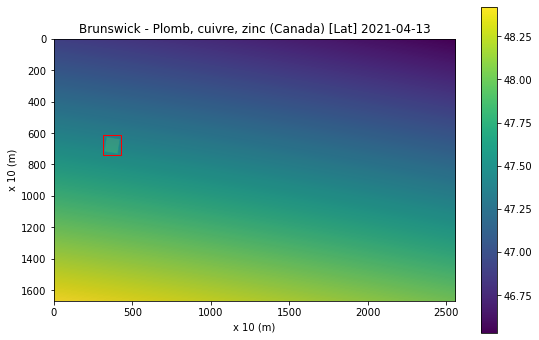

In [144]:
# Affichage de la latitude sur le fond de l'acquisition.
geo.plotmask(add='Lat')

## RVI résumé.

Un jeu de données (dataset) est stocké dans le répertoire temporaire après calcul. On y accède immédiatement. Ce dataset contient le RVI et des informations sur l'acquisition.

In [145]:
# Récupération des synthèses de calcul du RVI.
R = sentinel.dataset.rvi(zone)
R

,RVI,RMSE,INCIDENCE,ELEVATION,DIRECTION,DLAT,DLON,DX,DY,ZIPFILE,RVIC
DATE,,,,,,,,,,,
2019-10-21,1.373647,0.313226,44.000092,38.728700,1,0.004300,1.243266,9089.0,-1583.0,S1A_IW_GRDH_1SDV_20191021T222002_20191021T2220...,1.340133
2019-10-26,1.321213,0.307719,41.443747,36.590827,-1,0.689922,-0.453819,4551.0,-6791.0,S1B_IW_GRDH_1SDH_20191026T103044_20191026T1031...,1.369354
2019-11-01,1.346809,0.307528,41.442749,36.590027,-1,0.690018,-0.453393,4546.5,-6791.0,S1A_IW_GRDH_1SDH_20191101T103126_20191101T1031...,1.389983
2019-11-02,1.366708,0.312452,44.001338,38.729638,1,0.004309,1.244064,9098.5,-1583.0,S1A_IW_GRDH_1SDV_20191102T222002_20191102T2220...,1.369174
2019-11-07,1.225837,0.295337,41.448008,36.594379,-1,0.689966,-0.454961,4561.0,-6786.0,S1B_IW_GRDH_1SDH_20191107T103044_20191107T1031...,1.344998
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01,1.393306,0.315943,43.995191,38.724230,1,0.004568,1.244392,9094.5,-1573.0,S1A_IW_GRDH_1SDV_20210401T222005_20210401T2220...,1.323758
2021-04-06,1.340256,0.304899,41.454566,36.601529,-1,0.689580,-0.451993,4519.0,-6791.0,S1B_IW_GRDH_1SDH_20210406T103047_20210406T1031...,1.345739
2021-04-08,1.410045,0.313276,34.998373,31.101821,1,-0.012707,-0.795916,-6102.5,801.5,S1A_IW_GRDH_1SDV_20210408T221152_20210408T2212...,1.353186


Ces calculs peuvent être relancés par l'appel de `rvicompute()`. Pour relancer le calcul complet, par exemple dans le cas où l'on aurait modifié un code, il faut rajouter la commande `renew=True`.

In [146]:
# sentinel.rvicompute(zone)

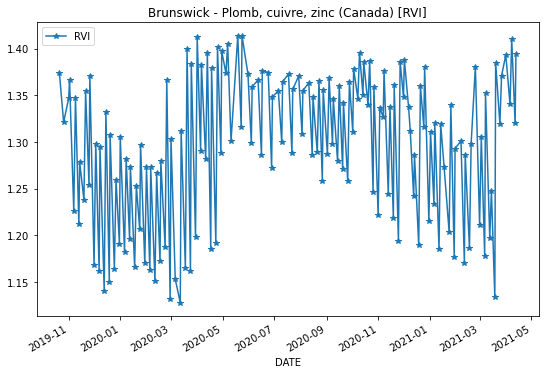

In [148]:
# Affichage de l'évolution du RVI.
sentinel.dataset.rviplot(zone)

On peut lisser RVI en calculant RVIC par la fonctuon `rvicorrect(zone,renew)`.

,RVI,RMSE,INCIDENCE,ELEVATION,DIRECTION,DLAT,DLON,DX,DY,ZIPFILE,RVIC
DATE,,,,,,,,,,,
2019-10-21,1.373647,0.313226,44.000092,38.728700,1,0.004300,1.243266,9089.0,-1583.0,S1A_IW_GRDH_1SDV_20191021T222002_20191021T2220...,1.340133
2019-10-26,1.321213,0.307719,41.443747,36.590827,-1,0.689922,-0.453819,4551.0,-6791.0,S1B_IW_GRDH_1SDH_20191026T103044_20191026T1031...,1.369354
2019-11-01,1.346809,0.307528,41.442749,36.590027,-1,0.690018,-0.453393,4546.5,-6791.0,S1A_IW_GRDH_1SDH_20191101T103126_20191101T1031...,1.389983
2019-11-02,1.366708,0.312452,44.001338,38.729638,1,0.004309,1.244064,9098.5,-1583.0,S1A_IW_GRDH_1SDV_20191102T222002_20191102T2220...,1.369174
2019-11-07,1.225837,0.295337,41.448008,36.594379,-1,0.689966,-0.454961,4561.0,-6786.0,S1B_IW_GRDH_1SDH_20191107T103044_20191107T1031...,1.344998
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01,1.393306,0.315943,43.995191,38.724230,1,0.004568,1.244392,9094.5,-1573.0,S1A_IW_GRDH_1SDV_20210401T222005_20210401T2220...,1.323758
2021-04-06,1.340256,0.304899,41.454566,36.601529,-1,0.689580,-0.451993,4519.0,-6791.0,S1B_IW_GRDH_1SDH_20210406T103047_20210406T1031...,1.345739
2021-04-08,1.410045,0.313276,34.998373,31.101821,1,-0.012707,-0.795916,-6102.5,801.5,S1A_IW_GRDH_1SDV_20210408T221152_20210408T2212...,1.353186


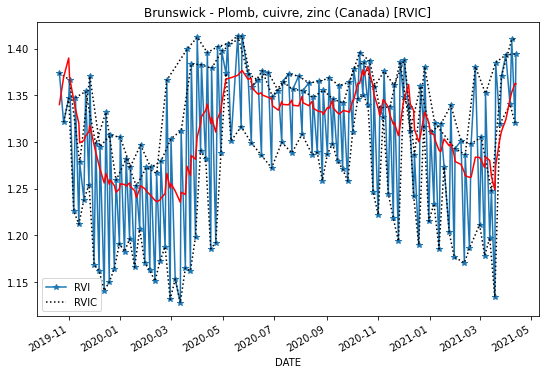

In [149]:
sentinel.dataset.rvicorrect(zone, plot=True)

## Informations supplémentaires.
L'objet GrdZone contient des éléments d'intérêts utiles à certains calculs.

### Position de la fenêtre d'acquisition.
La variable `geo.code` contient une table de positions spatiales ed'orientation du satellite. Cette table est sous-écahntillonnée par rapport aux pixels et lignes de l'image de 250 km x 170 km. Copernic précise que les valeurs intermédiaires peuvent se calculer à partir d'interpolations linéaires.

In [150]:
geo.code

,line,pixel,lat,lon,incidence,elevation
0,0,0,46.530688,-68.549063,30.546036,27.242091
1,0,1280,46.552578,-68.385963,31.436877,28.018242
2,0,2560,46.574417,-68.221350,32.323907,28.789610
3,0,3840,46.595840,-68.057982,33.187300,29.538308
4,0,5120,46.617178,-67.893342,34.045209,30.280717
...,...,...,...,...,...,...
205,16675,20480,48.352227,-66.271830,43.255239,38.109696
206,16675,21760,48.370183,-66.102969,43.929577,38.669992
207,16675,23040,48.387912,-65.933789,44.593446,39.219684
208,16675,24320,48.405516,-65.763274,45.254256,39.765495


### Les images numériques.
Elles sont contenues dans `geo.data` avec la date d'acquisition (initiale), la polarisation, l'orientation de l'image (Descending : il faudra la retourner pour la visualiser dans le sens habituel et les tailles initiales en lignes et pixels.

In [151]:
geo.data

[{'date': datetime.datetime(2021, 4, 13, 22, 20, 5, 951824),
  'polarisation': 'VH',
  'direction': 'Ascending',
  'heigth': 16676,
  'width': 25589,
  'image': array([[ 95, 117,  82, ...,  90,  80,  63],
         [ 99, 108,  81, ...,  90, 111,  74],
         [106, 102,  98, ..., 153, 160,  80],
         ...,
         [136, 110, 111, ..., 108,  88,  90],
         [104,  78,  84, ..., 118, 109, 142],
         [ 84,  54,  79, ..., 111, 143, 173]], dtype=uint16)},
 {'date': datetime.datetime(2021, 4, 13, 22, 20, 5, 951824),
  'polarisation': 'VV',
  'direction': 'Ascending',
  'heigth': 16676,
  'width': 25589,
  'image': array([[205, 169, 205, ..., 158, 133, 150],
         [230, 172, 160, ..., 161, 152, 144],
         [155, 113, 109, ..., 239, 212, 146],
         ...,
         [160, 248, 253, ..., 251, 263, 233],
         [239, 264, 224, ..., 193, 186, 133],
         [188, 204, 206, ..., 172, 209, 196]], dtype=uint16)}]

### Le masque géographique recherché.
Les images stockées dans `geo.data` sont des extraits rectangulaires définies par la bounding-box (`bbox`) du masque. Cette boite rectanglaire (carré rouge sur l'image produite par `plotmask()`) est définie par ses coins supérieur gauche et inférieur droit.

L'incidence et l'élévation sont des informations moyennes calculées sur la zone d'intérêt.

`dvec` est un vecteur géographique en coordonnées (latitude, longitude).

Les latitudes et longitudes sur l'image extraite sont données par ls tableaux `lat` et `lon`.

Finalement le tableau booléen `belong` donne les pixels de l'extraction qui appartiennet à notre zone géographique.

In [152]:
geo.mask

{'bbox': (21300, 6140, 22470, 7380),
 'incidence': 43.996910482334386,
 'elevation': 38.7258397701305,
 'dvec': (0.00449959942569933, 1.24405073671835),
 'dxy': (9090.5, -1578.0),
 'lat': array([[47.41727196, 47.41728606, 47.41730017, ..., 47.43356803,
         47.4335819 , 47.43359578],
        [47.4173618 , 47.4173759 , 47.41739   , ..., 47.43365786,
         47.43367174, 47.43368561],
        [47.41745164, 47.41746574, 47.41747984, ..., 47.4337477 ,
         47.43376158, 47.43377545],
        ...,
        [47.52840352, 47.52841758, 47.52843164, ..., 47.5446964 ,
         47.54471027, 47.54472415],
        [47.52849339, 47.52850745, 47.5285215 , ..., 47.54478624,
         47.54480011, 47.54481398],
        [47.52858326, 47.52859731, 47.52861137, ..., 47.54487608,
         47.54488995, 47.54490382]]),
 'lon': array([[-65.93860495, -65.93847501, -65.93834507, ..., -65.78712679,
         -65.78699714, -65.78686748],
        [-65.93862619, -65.93849625, -65.93836631, ..., -65.78714771,
 

_Jérôme Lacaille_